In [1]:
from bs4 import BeautifulSoup
import nltk
import random
import unicodedata
from os import listdir
from os.path import isfile, join
import math
import urllib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab

In [2]:
def converter(path):
    """Takes a path to a .txt file and returns a string of less than 50000 characters worth of 
    sentences"""
    soup = BeautifulSoup(open(path), "lxml")
    text = soup.get_text()
    # These are the usable sentences as the first and last are not from the actual text.
    sentences = nltk.sent_tokenize(text)[5:-150]
    # Takes all sentences that have more than 60 characters, and less than 600.
    good_sentences = [sentence for sentence in sentences if len(sentence) > 60 and len(sentence) < 600]
    # Appends the list of sentences, to form one long string
    final_sentences = []
    while len(''.join(final_sentences)) < 49000 and len(good_sentences) > 1:
        item = random.sample(good_sentences, 1)
        good_sentences.remove(item[0])
        final_sentences.append(unicodedata.normalize('NFKD', item[0]).encode('ascii','ignore'))
    return ' '.join(final_sentences)

In [3]:
def vector_creator(adir):
    """Takes a directory with .txt files and returns a list with a string of less than 50000 characters worth of 
    sentences for each of these files."""
    allfiles = [f for f in listdir(adir) if isfile(join(adir, f))]
    vector = [converter(adir + '/' + files) for files in allfiles]
    return vector

This is the part of the code that computes the actual sentiment of the documents, and the t-test of different attributes (negative, positive and neutral)

In [4]:
def basic_sentiment(lot):
    """Takes a list of texts and computes the sentiment of each of these text and 
    returns them as a list of a dictionary that still needs to be evaluated."""
    lot_values = []
    for text in lot:
        data = urllib.urlencode({"text": text})
        u = urllib.urlopen("http://text-processing.com/api/sentiment/", data)
        lot_values.append(u.read())
    return lot_values

In [5]:
def averages(lot):
    """Takes a list of strings and returns a dictionary with the mean and standard deviation
    for pos, neg an neutral values."""
    values = basic_sentiment(lot)
    
    pos = [eval(a_dict)["probability"]["pos"] for a_dict in values]
    neg = [eval(a_dict)["probability"]["neg"] for a_dict in values]
    neutral = [eval(a_dict)["probability"]["neutral"] for a_dict in values]

    mean_pos = sum(pos, 0.0) / len(pos)
    mean_neg = sum(neg, 0.0) / len(neg)
    mean_neutral = sum(neutral, 0.0) / len(neutral)
                   
    d_pos = [(i - mean_pos) ** 2 for i in pos]
    std_dev_pos = math.sqrt(sum(d_pos) / len(d_pos))
                   
    d_neg = [(i - mean_neg) ** 2 for i in neg]
    std_dev_neg = math.sqrt(sum(d_neg) / len(d_neg))
    
    d_neutral = [(i - mean_neutral) ** 2 for i in neutral]
    std_dev_neutral = math.sqrt(sum(d_neutral) / len(d_neutral))
    
    return {"mean pos": mean_pos,
            "mean neg": mean_neg,                 
            "mean neutral": mean_neutral,
            "std dev pos": std_dev_pos,
            "std dev neg": std_dev_neg,
            "std dev neutral": std_dev_neutral}

In [13]:
def Cohen(avr_1, avr_2, attribute):
    """Takes two dictionairies and an attribute on which the t_test will be computed.
    The attribute can be either neg, pos or neutral. It will return a t_score."""
    length1 = avr_1["length"]
    length2 = avr_2["length"]
    mean1 = avr_1["mean " + attribute]
    mean2 = avr_2["mean " + attribute]
    var1 = avr_1["std dev " + attribute]
    var2 = avr_2["std dev " + attribute]
    return (mean1 - mean2) / math.sqrt(((length1 - 1)*var1**2 + (length2 - 1)*var2**2)/
                                       (length1 + length2 - 2))

In [7]:
# Total code
def total(iterations, adir):
    """Combines all the code, so you give it a directory with txt files and it returns
    a dictionairy with all the average values for the mean and standard deviations. This 
    code also runs this a couple of itterations to make sure the data is reliable because
    we take a random sample of the sentences of each text."""
    total_dict = {"mean pos": 0, "mean neg": 0, "mean neutral": 0, "std dev pos": 0,
                  "std dev neg": 0, "std dev neutral": 0, "length": 0}
    for i in range (iterations):
        vector = vector_creator(adir)
        adict = averages(vector)
        adict["length"] = len(vector)
        total_dict = dict((n, total_dict.get(n, 0) + adict.get(n, 0)) 
                          for n in set(adict)|set(total_dict))
    for key, value in total_dict.items():
        total_dict[key] = value / iterations
    return total_dict

In [8]:
EF18 = total(4, "/Users/imac/Desktop/18FE")
EM18 = total(4, "/Users/imac/Desktop/18ME")
EF19 = total(4, "/Users/imac/Desktop/19FE")
EM19 = total(4, "/Users/imac/Desktop/19ME")
AM19 = total(4, "/Users/imac/Desktop/19MA")
AF19 = total(4, "/Users/imac/Desktop/19FA")

The following code is there to visualise the results I found

In [9]:
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [10]:
def plot_it(sent, century, gender, country):
    """Plots the data found, takes a sentiment, either pos neg or neutral, 
    century which is either 18 or 19, gender, either Male or Female, and
    a country which is either America or England. All of these inputs are 
    strings."""
    x = np.linspace(0, 1, 100)
    a_dict = eval(country[0] + gender[0] + century)
    if gender == 'Male': color = "darkblue"
    else: color = "deeppink"
    if century == '18': linestyle = 'dashed'
    else: linestyle = 'solid'
    if country == 'England': size = 1
    else: size = 3
    label = gender + ' sentiment\n in the ' + century + 'th century\n in ' + country
    plt.plot(x, mlab.normpdf(x, a_dict["mean " + sent], a_dict["std dev " + sent]), 
             linestyle=linestyle, color=color, label=label, linewidth=size)

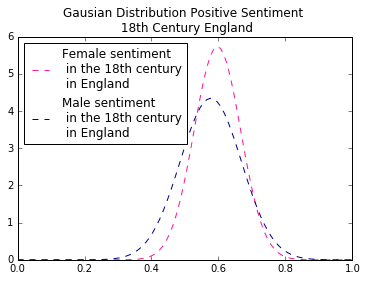

Cohen score:  -0.242784527854 



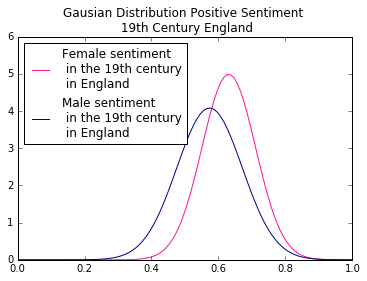

Cohen score:  -0.642291481163 



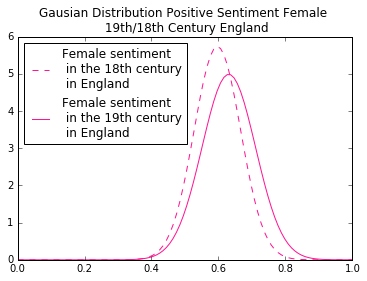

Cohen score:  -0.450871518459 



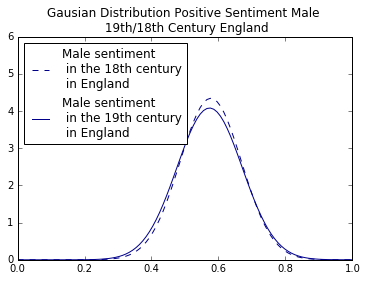

Cohen score:  0.0376157428795 



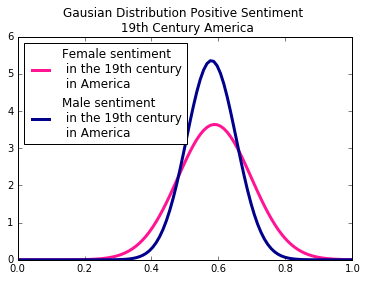

Cohen score:  -0.103187554972 



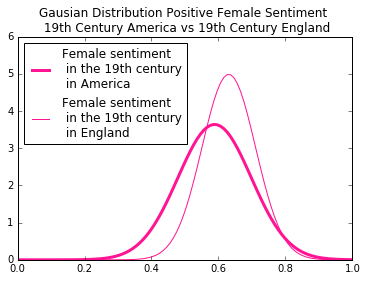

Cohen score:  -0.440891084784 



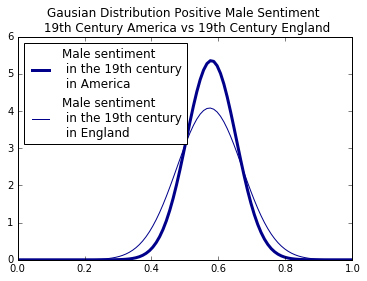

Cohen score:  0.0620420413986


In [14]:
plt.title('Gausian Distribution Positive Sentiment \n 18th Century England')
plot_it('pos', '18', 'Female', 'England')
plot_it('pos', '18', 'Male', 'England')
plt.legend(loc='best')
pylab.ylim([0,6])
pylab.xlim([0,1])
plt.savefig('EF18_EM18.png')
plt.show()
print 'Cohen score: ', Cohen(EM18, EF18, "pos"), '\n'

plt.title('Gausian Distribution Positive Sentiment \n 19th Century England')
plot_it('pos', '19', 'Female', 'England')
plot_it('pos', '19', 'Male', 'England')
plt.legend(loc='best')
pylab.ylim([0,6])
pylab.xlim([0,1])
plt.savefig('EF19_EM19.png')
plt.show()
print 'Cohen score: ', Cohen(EM19, EF19, "pos"), '\n'

plt.title('Gausian Distribution Positive Sentiment Female \n 19th/18th Century England')
plot_it('pos', '18', 'Female', 'England')
plot_it('pos', '19', 'Female', 'England')
plt.legend(loc='best')
pylab.ylim([0,6])
pylab.xlim([0,1])
plt.savefig('EF18_EF19.png')
plt.show()
print 'Cohen score: ', Cohen(EF18, EF19, "pos"), '\n'

plt.title('Gausian Distribution Positive Sentiment Male \n 19th/18th Century England')
plot_it('pos', '18', 'Male', 'England')
plot_it('pos', '19', 'Male', 'England')
plt.legend(loc='best')
pylab.ylim([0,6])
pylab.xlim([0,1])
plt.savefig('EM18_EM19.png')
plt.show()
print 'Cohen score: ', Cohen(EM18, EM19, "pos"), '\n'

plt.title('Gausian Distribution Positive Sentiment \n 19th Century America')
plot_it('pos', '19', 'Female', 'America')
plot_it('pos', '19', 'Male', 'America')
plt.legend(loc='best')
pylab.ylim([0,6])
pylab.xlim([0,1])
plt.savefig('AF19_AM19.png')
plt.show()
print 'Cohen score: ', Cohen(AM19, AF19, "pos"), '\n'

plt.title('Gausian Distribution Positive Female Sentiment \n 19th Century America vs 19th Century England')
plot_it('pos', '19', 'Female', 'America')
plot_it('pos', '19', 'Female', 'England')
plt.legend(loc='best')
pylab.ylim([0,6])
pylab.xlim([0,1])
plt.savefig('AF19_EF19.png')
plt.show()
print 'Cohen score: ', Cohen(AF19, EF19, "pos"), '\n'

plt.title('Gausian Distribution Positive Male Sentiment \n 19th Century America vs 19th Century England')
plot_it('pos', '19', 'Male', 'America')
plot_it('pos', '19', 'Male', 'England')
plt.legend(loc='best')
pylab.ylim([0,6])
pylab.xlim([0,1])
plt.savefig('AM19_EM19.png')
plt.show()
print 'Cohen score: ', Cohen(AM19, EM19, "pos")